In [1]:
import sys

sys.path.append('/Users/vivekkrishnan/Workspaces/Software Workspace/Kirian-Lab/microjets/')


import os
import glob

import numpy as np

from skimage import measure, morphology
from scipy import ndimage
from matplotlib import pyplot as plt

from microjet_analysis import dataio


In [2]:
def first_filter_img(img, f_sigma = 10, **kwargs):
    return ndimage.gaussian_filter(img, sigma=f_sigma) - img
def second_filter_img(img, **kwargs):
    return (morphology.white_tophat(img) - img).clip(min=0)
def threshold_img(img, t_sigma = 5, **kwargs):
    return np.array((img > np.mean(img) + t_sigma * np.std(img)))

def remove_jet_region(img, **kwargs):
	x = np.sum(img, axis=0) > 0
	max_subset = []
	current_max_subset = []
	for i, n in enumerate(x):
		if n:
			current_max_subset.append(i)
			if len(current_max_subset) > len(max_subset):
				max_subset = current_max_subset
		else:
			current_max_subset = []
	img[:,max_subset[0]:] = 0
	return img

def process_img(binary_img, p_blur=0.75, **kwargs):
    r"""Make sure to remove the nozzle tip and jet before processing"""
    processed = binary_img.copy()
    ndimage.gaussian_filter(1.0*processed, sigma=p_blur)
    ndimage.binary_opening(1.0*(processed > np.mean(processed)), structure=np.ones((5, 5)),iterations=1,).astype(int)
    ndimage.binary_fill_holes(1.0*processed)
    return 1.0*processed

def centroid_img(binary_img, method = 'regular', **kwargs):
    centroid_x, centroid_y = [],[]
    if method == 'regular':
        props = measure.regionprops_table(measure.label(binary_img), properties=['centroid'])
        centroid_x = props['centroid-1'].astype(int)
        centroid_y = props['centroid-0'].astype(int)
    return centroid_x, centroid_y

def mask_centroids(img_shape, centroid_x, centroid_y, m_blur = 1, **kwargs):
    droplet_mask = np.zeros(img_shape)
    if len(centroid_y) > 0 and len(centroid_x) > 0:droplet_mask[centroid_y, centroid_x] = 1
    droplet_mask = ndimage.gaussian_filter(droplet_mask, m_blur) > np.mean(droplet_mask)
    return droplet_mask

def all_steps(raw_img, centroids=False, **kwargs):

    gauss_filtered = first_filter_img(raw_img, **kwargs)
    toph_filtered = second_filter_img(gauss_filtered, **kwargs)
    thresholded = threshold_img(toph_filtered, **kwargs)
    droplet_region = remove_jet_region(thresholded, **kwargs)
    processed = process_img(droplet_region, **kwargs)
    final_img = mask_centroids(processed.shape, *centroid_img(processed,**kwargs)) if centroids else processed.copy()
    return final_img

In [3]:
import multiprocessing.pool as mp
def process_img_stack(img_stack, **config):

    _img_stack = img_stack.copy()

    config.setdefault('normalize', True)
    config.setdefault('brightfield', False)
    config.setdefault('use_centroids', False)


    if config['normalize']: _img_stack /= 255
    if config['brightfield']: _img_stack = 1-_img_stack if config['normalize'] else 255-_img_stack

    with mp.ThreadPool(10) as pool:
        _processed_img_stack = pool.starmap(all_steps,zip(_img_stack, [config['use_centroids']]*len(_img_stack)), chunksize=5)
    return np.array(_processed_img_stack)

In [4]:
def calculate_jet_speed(pfx, psx, dat):
	_displacement = np.sqrt(pfx ** 2 + psx ** 2)
	_jet_speed = _displacement * (dat['pixel_size'] * 1e-6) / (dat['delay'] * 1e-9)
	return _displacement, _jet_speed

def pad(im):
	ns, nf = im.shape
	return np.pad(im.copy(), ((int(ns / 2), int(ns / 2)), (int(nf / 2), int(nf / 2))))
def cross_correlation_calculation(cc, nf, ns):
	w = np.where(cc == np.max(cc))
	_pf = w[1][0] - np.floor(nf / 2)
	_ps = w[0][0] - np.floor(ns / 2)
	return _pf, _ps
def cross_correlate(im1, im2, use_autocorrelation = True):
    _cc = np.real(np.fft.ifftn(np.fft.fftn(im1) * np.conj(np.fft.fftn(im2))))
    _ac = np.real(np.fft.ifftn(np.abs(np.fft.fftn(im1)) ** 2)) + np.real(np.fft.ifftn(np.abs(np.fft.fftn(im2)) ** 2)) if use_autocorrelation else np.zeros_like(_cc)
    return _cc, _ac
def correlation_matrix_2d(_img_stack, use_autocorrelation = True, correction = True):
    n_frames, ns, nf = _img_stack.shape
    ccsum = 0
    acsum = 0

    img_grouping = []

    for i in range(0, n_frames-1, 2):
        img_grouping.append([pad(_img_stack[i]),pad(_img_stack[i+1]), use_autocorrelation])

    with mp.ThreadPool(10) as pool: #Multiprocessing instead of threading would be faster here
        res = np.array(pool.starmap(cross_correlate,img_grouping))
        ccsum = sum(res[:,0])
        acsum = sum(res[:,1])

    _cc =  np.fft.fftshift(ccsum / np.sum(ccsum) - acsum / np.sum(acsum)) if use_autocorrelation \
        else np.fft.fftshift(ccsum / np.sum(ccsum))
    _cc = _cc[int(ns / 2):ns + int(ns / 2), int(nf / 2):nf + int(nf / 2)].clip(min=0)
    _pf, _ps = cross_correlation_calculation(_cc, nf, ns)
    if correction:
        right = _cc[:, nf // 2:]
        c_left = np.rot90(_cc[:, 0:nf // 2], 2)
        diff = (right - c_left).clip(min=0)
        c_pf, c_ps = cross_correlation_calculation(diff, 0, ns)
        print(f"pf,ps:{_pf,_ps}; n_pf,n_ps:{c_pf,c_ps}")
        return diff, c_pf, c_ps

    return cc, pf, ps

048.h5 0
pf,ps:(45.0, -2.0); n_pf,n_ps:(45.0, -2.0)
Jet Speed = 42.96, (LF,GF):(7.73, 15.03)


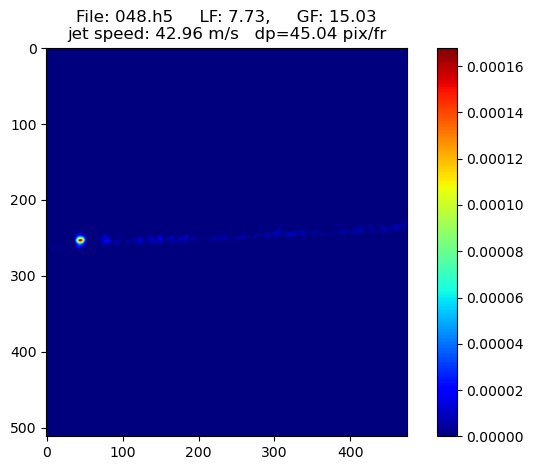

019.h5 1
pf,ps:(103.0, -5.0); n_pf,n_ps:(103.0, -5.0)
Jet Speed = 98.36, (LF,GF):(2.18, 20.0)


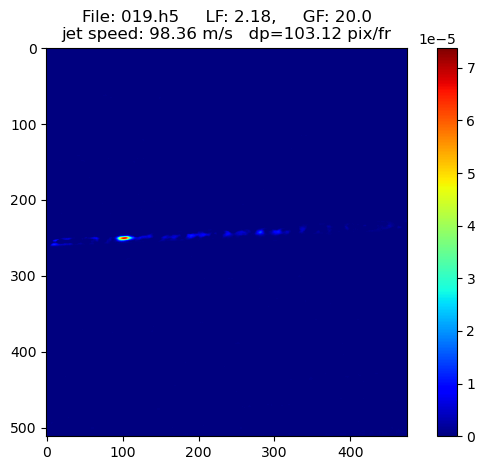

009.h5 2
pf,ps:(93.0, -4.0); n_pf,n_ps:(93.0, -4.0)
Jet Speed = 88.79, (LF,GF):(1.68, 19.99)


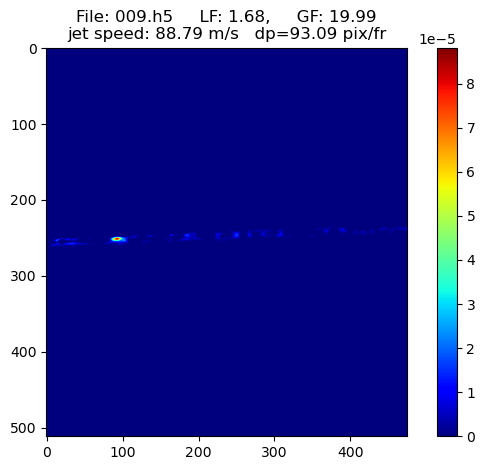

058.h5 3
pf,ps:(42.0, -1.0); n_pf,n_ps:(42.0, -1.0)
Jet Speed = 40.07, (LF,GF):(14.55, 30.03)


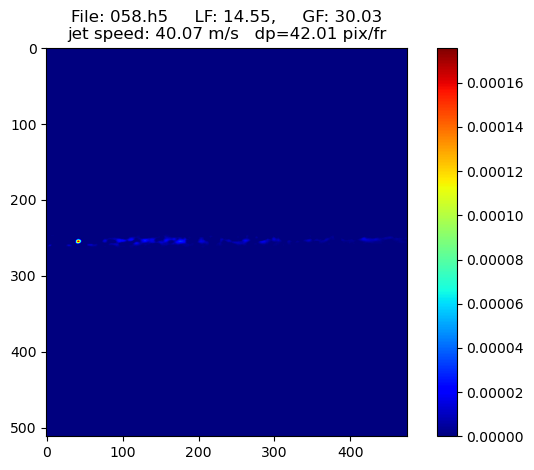

029.h5 4
pf,ps:(10.0, -2.0); n_pf,n_ps:(144.0, -6.0)
Jet Speed = 137.47, (LF,GF):(1.71, 34.01)


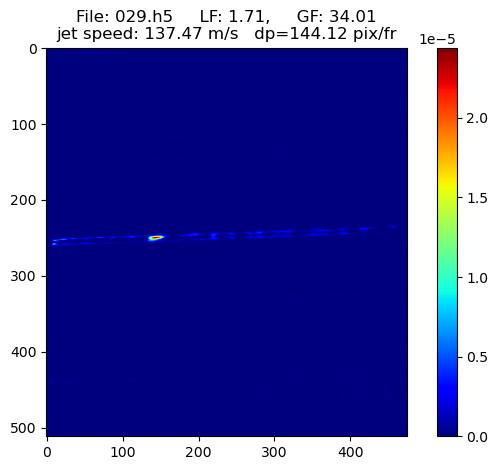

Files: ['048', '019', '009', '058', '029']

Gas Flows: [15.03, 20.0, 19.99, 30.03, 34.01]

Liq Flows: [7.73, 2.18, 1.68, 14.55, 1.71]

Jet Speeds: [42.96, 98.36, 88.79, 40.07, 137.47]

Displacement: [45.04, 103.12, 93.09, 42.01, 144.12]


In [5]:
import collections
import time

filepath_config = dict(
        base_path = "/Users/vivekkrishnan/Workspaces/Software Workspace/Kirian-Lab/microjets/data",
        date = "20221215",
        nozzle_id = "79V1-DB-50G-50L-221205-02_G100")

use_centroids = False
use_autocorrelation = True
correction = True


path = os.path.join(*list(filepath_config.values()))

filepaths = glob.glob(os.path.join(path, "*.h5"))
file_arr, gas_flow_arr, liq_flow_arr, jet_speed_arr, displacement_arr = ([] for _ in range(5))

for i, filepath in enumerate(filepaths[0:5]):

    f = os.path.basename(filepath)
    print(f, i)
    raw_img_stack, data = dataio.h5_metadata_version(filepath)
    raw_img_stack = np.array([np.transpose(img[0:950]) for img in raw_img_stack])

    processed_img_stack = process_img_stack(raw_img_stack, use_centroids=use_centroids)

    cc, pf, ps = correlation_matrix_2d(processed_img_stack, correction=correction, use_autocorrelation=use_autocorrelation)
    jet_speed = round(calculate_jet_speed(pf, ps, data)[1], 2)
    displacement = round(calculate_jet_speed(pf, ps, data)[0], 2)
    print(f"Jet Speed = {jet_speed}, (LF,GF):{round(data['liquid_flow'],2),data['gas_flow']}")
    plt.imshow(cc, cmap='jet')
    plt.title(
			f"File: {f}     LF: {round(data['liquid_flow'],2)},     GF: {data['gas_flow']}\njet speed: {jet_speed} m/s   dp={displacement} pix/fr")
    plt.tight_layout()
    plt.colorbar()
    plt.savefig(f"{path}_analysis/correlations/{f[0:3]}.png", bbox_inches='tight')
    plt.show()

    file_arr += [f[0:3]]
    gas_flow_arr += [data['gas_flow']]
    liq_flow_arr += [round(data['liquid_flow'],2)]
    jet_speed_arr += [jet_speed]
    displacement_arr += [displacement]
print(f"Files: {file_arr}")
print(f"\nGas Flows: {gas_flow_arr}")
print(f"\nLiq Flows: {liq_flow_arr}")
print(f"\nJet Speeds: {jet_speed_arr}")
print(f"\nDisplacement: {displacement_arr}")